In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
def trim(image):
    left = -1
    right = -1
    top = -1
    bottom = -1

    for i in range(image.shape[0]):
        if np.any(image[i] > 0):
            top = i
            break
    for i in range(image.shape[0] - 1, -1, -1):
        if np.any(image[i] > 0):
            bottom = i
            break
    for i in range(image.shape[1]):
        if np.any(image[:, i] > 0):
            left = i
            break
    for i in range(image.shape[1] - 1, -1, -1):
        if np.any(image[:, i] > 0):
            right = i
            break
    print(left, right, top, bottom)
    image = image[top:bottom, left:right]
    return image , left, right, top, bottom


In [3]:
testImagePaths = ['/Users/nuhash/Downloads/test13_53_2.PNG', '/Users/nuhash/Downloads/test18_50_25.PNG', '/Users/nuhash/Downloads/acne_breakouts.PNG']
maskImagePaths = ['/Users/nuhash/Downloads/test13_53_2.PNG', '/Users/nuhash/Downloads/test18_50_25.PNG', '/Users/nuhash/Downloads/test16_17_0.PNG']

In [4]:
def convert_range(currentL, currentR, newL, newR, value):
    return (value - currentL) * (newR - newL) / (currentR - currentL) + newL

In [5]:
def ellipse_line_intersection(x1, y1, h, k, a, b):
    # Step 1: Calculate the terms in the equation for t
    A = (h - x1)**2 / a**2 + (k - y1)**2 / b**2
    
    if A == 0:
        return None  # The line does not intersect the ellipse
    
    # Step 2: Calculate t (both positive and negative roots)
    t1 = np.sqrt(1 / A)
    t2 = -t1
    
    # Step 3: Find the intersection points (x, y)
    intersection_1 = (x1 + t1 * (h - x1), y1 + t1 * (k - y1))
    intersection_2 = (x1 + t2 * (h - x1), y1 + t2 * (k - y1))
    
    return intersection_1, intersection_2

In [6]:
def ellipse_intersection(x, y, h, k, a, b):
    denom = ( (x - h) * 2 / a * 2 ) + ( (y - k) * 2 / b * 2 )
    if(denom == 0):
        return None
    val  = np.sqrt(1 / denom)
    if 1 + val >= 0 and 1 + val:
        t = 1 + val
    else:
        t = 1 - val
    
    X_int = x + t * (h - x)
    Y_int = y + t * (k - y)
    
    return X_int, Y_int 


In [7]:
def find_min_distance(x1, y1, h, k, a, b):
    try:
        p1, p2 = ellipse_line_intersection(x1, y1, h, k, a, b)
        dist1 = np.sqrt((p1[0] - x1)**2 + (p1[1] - y1)**2)
        dist2 = np.sqrt((p2[0] - x1)**2 + (p2[1] - y1)**2)
        return min(dist1, dist2)
    except:
        return 0

In [8]:
def point_distance_from_ellipse(x_p, y_p, h, k, a, b):
    value = ((x_p - h) ** 2) / (a ** 2) + ((y_p - k) ** 2) / (b ** 2)
    return value

In [9]:
from scipy.special import comb

def smoothstep(x, x_min=0, x_max=1, N=1):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)

    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n

    result *= x ** (N + 1)

    return result

660 1073 1613 1793
threshold_value 210.0
minVal 0.0 maxVal 241.0 minLoc (52, 15) maxLoc (273, 85)
max_distance 4050.45
min_distance 353.44


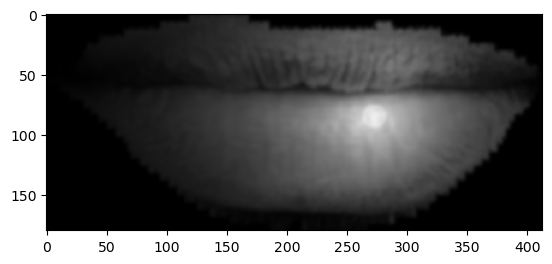

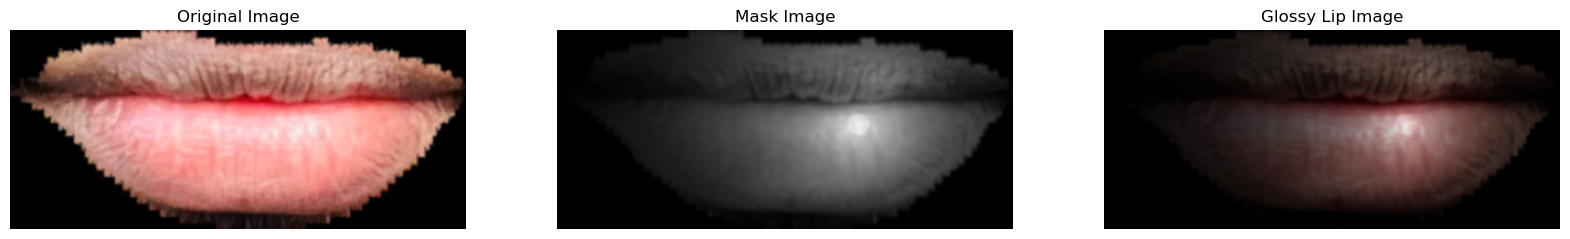

In [10]:
image, left, right, top, bottom = trim(cv2.imread(testImagePaths[0]))  # Replace with your image path
mask = (cv2.imread(maskImagePaths[0], cv2.IMREAD_GRAYSCALE))  # Replace with your mask path
mask = mask[top:bottom, left:right]


image = cv2.GaussianBlur(image, (5, 5), 0)
mask = cv2.GaussianBlur(mask, (5, 5), 0)


masked_image = cv2.bitwise_and(image, image, mask=mask)
gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

masked_pixels = gray_image[mask > 127]
threshold_value = np.percentile(masked_pixels, 90)
print("threshold_value", threshold_value)
_, lip_mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(gray_image, mask=mask)
print("minVal", minVal , "maxVal", maxVal, "minLoc", minLoc, "maxLoc", maxLoc)

center = maxLoc
radius = 100
elipse_a = 10
elipse_b = 5

lip_image = np.float32(image) / 255.0

overlay = np.zeros_like(lip_image)
rows, cols, _ = image.shape
max_distance = 0.0
min_distance = 10000000000000


for i in range(rows):
    for j in range(cols):
        distance = point_distance_from_ellipse(j, i, center[1], center[0], elipse_a, elipse_b)
        if(distance < 1):
            continue
        else:
            max_distance = max(max_distance, distance)
            min_distance = min(min_distance, distance)
print("max_distance", max_distance)
print("min_distance", min_distance)
# for i in range(rows):
#     for j in range(cols):
#         distance = point_distance_from_ellipse(j, i, center[1], center[0], elipse_a, elipse_b)
#         # if the point is inside the ellipse, set the pixel value to 1
#         intensity = 0
#         if distance < 1:
#             intensity = 1
#         else:
#             intensity =  1 - convert_range(min_distance, max_distance, 0, 1, distance)
#         gray_pixel = gray_image[i, j] / 255.0
#         overlay[i, j] = [intensity * gray_pixel] * 3

        
for i in range(rows):
    for j in range(cols):
        distance = np.sqrt((i - center[1])**2 + (j - center[0])**2)
        if(distance < 10.0):
            distance = 0;
        intensity = np.exp(-distance / radius)
        gray_pixel = gray_image[i, j] / 255.0
        # gray_pixel = convert_range(0, 1, 0.5, 1, gray_pixel)

        overlay[i, j] = [intensity * gray_pixel] * 3


overlay = cv2.GaussianBlur(overlay, (5,5), 0)
plt.imshow(overlay)
# overlay *= 0.5  # Adjust the intensity of the overlay

# Apply the glossy effect only to the lip region using the mask
glossy_image = lip_image * overlay

lip_mask_3ch = cv2.merge([lip_mask, lip_mask, lip_mask]) / 255.0
glossy_lip_region = lip_image * (1 - lip_mask_3ch) + glossy_image * lip_mask_3ch
glossy_lip_image = np.uint8(glossy_lip_region * 255)

# plot the images
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title("Mask Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(glossy_image, cv2.COLOR_BGR2RGB))
plt.title("Glossy Lip Image")
plt.axis("off")

plt.show()


660 1073 1613 1793
threshold_value 227.0
minVal 0.0 maxVal 241.0 minLoc (52, 15) maxLoc (273, 85)


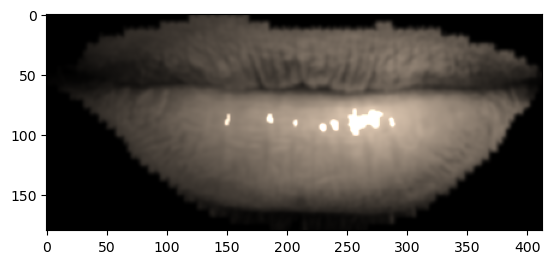

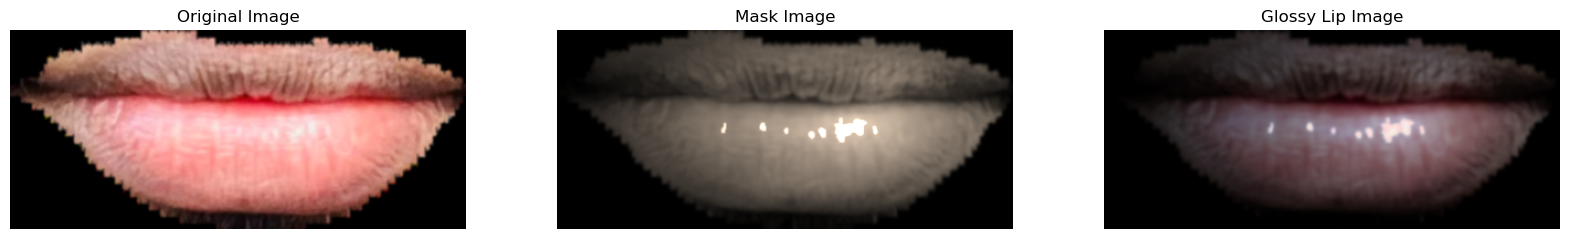

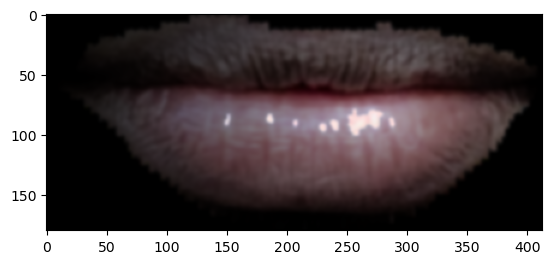

772 1353 1728 2052
threshold_value 209.0
minVal 1.0 maxVal 239.0 minLoc (107, 8) maxLoc (120, 203)


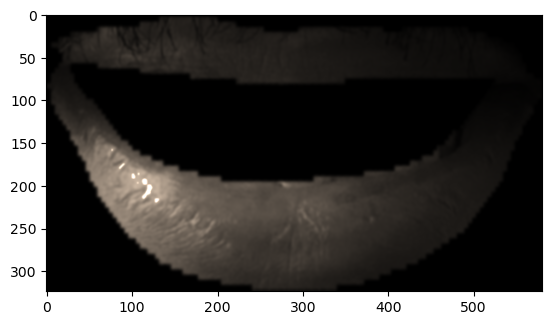

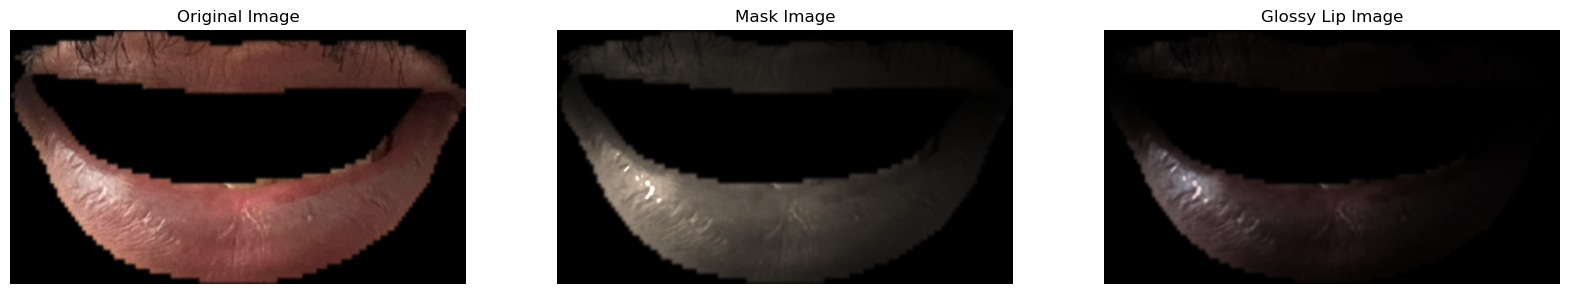

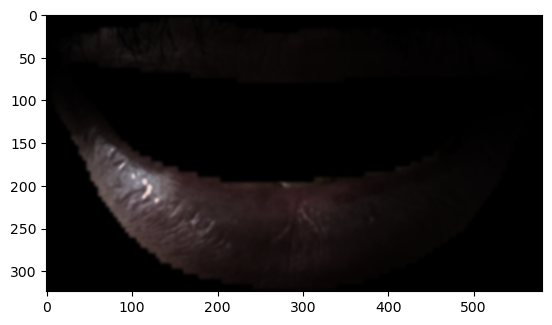

In [13]:
for index in range(2):
    image, left, right, top, bottom = trim(cv2.imread(testImagePaths[index]))  # Replace with your image path
    mask = (cv2.imread(maskImagePaths[index], cv2.IMREAD_GRAYSCALE))  # Replace with your mask path
    mask = mask[top:bottom, left:right]


    image = cv2.GaussianBlur(image, (5, 5), 0)
    mask = cv2.GaussianBlur(mask, (5, 5), 0)


    masked_image = cv2.bitwise_and(image, image, mask=mask)
    gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    masked_pixels = gray_image[mask > 127]
    threshold_value = np.percentile(masked_pixels, 99)
    print("threshold_value", threshold_value)
    _, lip_mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)

    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(gray_image, mask=mask)
    print("minVal", minVal , "maxVal", maxVal, "minLoc", minLoc, "maxLoc", maxLoc)

    center = maxLoc
    radius = 100
    elipse_a = 5
    elipse_b = 10

    lip_image = np.float32(image) / 255.0

    overlay = np.zeros_like(lip_image)
    rows, cols, _ = image.shape
    maximum_distance = 0.0
    minimum_distance = 10000000000000
    for i in range(rows):
        for j in range(cols):
            # if the point is inside the ellipse, set the pixel value to 1
            distance = (i - center[1])**2 / elipse_a**2 + (j - center[0])**2 / elipse_b**2
            distance = np.sqrt(distance)
            if distance < 1:
                continue
            else:
                maximum_distance = max(maximum_distance, distance)
                minimum_distance = min(minimum_distance, distance)

    for i in range(rows):
        for j in range(cols):
            # if the point is inside the ellipse, set the pixel value to 1
            distance = (i - center[1])**2 / elipse_a**2 + (j - center[0])**2 / elipse_b**2
            distance = np.sqrt(distance)
            intensity = 0
            if distance < 1:
                intensity = 1
            else:
                intensity = 1 - convert_range(minimum_distance, maximum_distance, 0, 1, distance)
            gray_pixel = gray_image[i, j] / 255.0
            overlay[i, j] = [intensity * gray_pixel, intensity * gray_pixel * 0.9, intensity * gray_pixel * 0.8]
            



    overlay = cv2.GaussianBlur(overlay, (5,5), 0)
    # lip_mask = cv2.medianBlur(lip_mask, 5)
    lip_mask = cv2.morphologyEx(lip_mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    lip_mask = cv2.GaussianBlur(lip_mask, (3,3), 0)
    # plt.imshow(overlay)
    # overlay *= 0.5  # Adjust the intensity of the overlay



    for i in range(rows):
        for j in range(cols):
            overlay[i, j] = overlay[i, j] + overlay[i, j] * lip_mask[i, j] / 255.0
            overlay[i,j] = np.clip(overlay[i,j], 0, 1)

    plt.imshow(overlay)

    # Apply the glossy effect only to the lip region using the mask
    glossy_image = lip_image * overlay
    glossy_image = cv2.GaussianBlur(glossy_image, (5,5), 0)
    # plot the images
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Mask Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(glossy_image, cv2.COLOR_BGR2RGB))
    plt.title("Glossy Lip Image")
    plt.axis("off")

    plt.show()


    plt.imshow(cv2.cvtColor(glossy_image, cv2.COLOR_BGR2RGB))
    plt.show()
    cv2.imwrite(f'input_{index}.png', image)
